# Model Training and Evaluation

## Configurações e Dataprep

In [1]:
## bibliotecas
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *

from utils.eda import *
from utils.modelling_tools import *

In [2]:
## configurações

np.set_printoptions()
np.set_printoptions(precision=4, suppress=True)

pd.options.display.float_format = '{:.4f}'.format

%matplotlib inline
from matplotlib import rcParams

plt_params = {
    'figure.figsize':(6,4),
    'figure.dpi':75,
    'font.size':16,
    'font.family':'serif',
    'xtick.labelsize':14,
    'ytick.labelsize':14,
    'axes.labelsize':14,
    'legend.fontsize':10,
    'lines.linewidth':12,
    'grid.color':'gray',
    'savefig.bbox':'tight',
    'savefig.dpi':1000,
    'savefig.transparent':False,
}

rcParams.update(plt_params)

import warnings
warnings.filterwarnings('ignore')

seed = 123

%load_ext autoreload
%autoreload 2

In [3]:
## Carregando dataset
df_raw = pd.read_csv('data.csv', sep=';')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
## Definição da variável-resposta
actual_target = 'y'
df_raw[actual_target].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [5]:
## mapeando a variável-resposta para numeric
target_map = {'no':0, 'yes':1}
df_raw['response'] = df_raw[actual_target].map(target_map)

#### IV e WoE

In [6]:
#### IV 
iv, woe = iv_woe(data=df_raw.drop('y', axis=1),
                         target='response',
                         bins=10, show_woe=False)

iv['Predictive Power'] = iv['IV'].map(predictive_power)

Information value of age is 0.139397
Information value of job is 0.188713
Information value of marital is 0.028215
Information value of education is 0.048576
Information value of default is 0.127776
Information value of housing is 0.001383
Information value of loan is 0.000269
Information value of contact is 0.251663
Information value of month is 0.485117
Information value of day_of_week is 0.006493
Information value of duration is 1.961794
Information value of campaign is 0.054246
Information value of pdays is 0.0
Information value of previous is 0.3505
Information value of poutcome is 0.547671
Information value of emp.var.rate is 1.06975
Information value of cons.price.idx is 0.440236
Information value of cons.conf.idx is 0.86074
Information value of euribor3m is 1.046047
Information value of nr.employed is 1.173723


### BASE SEM MANIPULAÇÃO

In [7]:
numerics = ['int16','int32','int64','float16','float32','float64']
numeric_features = df_raw.select_dtypes(include=numerics).columns
df_raw = df_raw[numeric_features]

## Separando bases de Treino e Teste
y = df_raw['response']
X = df_raw.drop('response', axis=1)


In [8]:
feature_names = X.columns
feature_names

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [9]:

from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

## dataset para estudo
df = pd.concat([X_train, pd.DataFrame(y_train, columns=['response'])], axis=1).reset_index(drop=True)

## dataset para teste OOS
df = pd.concat([X_test, pd.DataFrame(y_test, columns=['response'])], axis=1).reset_index(drop=True)

In [10]:
## Proporção das Classes
p_class0 = np.sum(y_train==0)/y_train.shape[0]
p_class1 = np.sum(y_train==1)/y_train.shape[0]

print(f'Proporção da Classe 0: {p_class0:.2%}')
print(f'Proporção da Classe 1: {p_class1:.2%}')

Proporção da Classe 0: 88.73%
Proporção da Classe 1: 11.27%


## Data Undersample (RUS)

Melhorando a classificação criando bases com o mesmo numero de entradas para cada classe.  

obs. a Amostra Aleatório Simples em uma unica exceção. o correto é escolher ao menos 5 AAS distintas (sem reposição) e avaliar se todas levam ao mesmo resultado de KS.  
Outra alternativa é que a distribuição da amostra seja representativa quando comparada a população

In [11]:
## Proporção de classe 0 para classe 1.
## Se 1, num_0 = num_1. Se 2, num_0 = 2*num_1
class1_prop = 1 ## inteiro

## Contando o numero da classe com menos observações, para fazer a extração do excedente
sample_size = y_train[y_train==0].shape[0] - class1_prop * np.sum(y_train==1)
class0_idx = np.where(y_train==0)[0]
class1_idx = np.where(y_train==1)[0]

## AAS dos indices da classe 0 ser removido
class0_random_indices = np.random.choice(class0_idx, sample_size, replace=False)

In [12]:
## Base de Dados com RUS (removendo os indices sorteados)
X_train_RUS = np.delete(X_train, class0_random_indices, axis=0) 
y_train_RUS = np.delete(y_train, class0_random_indices, axis=0)

In [13]:
## Proporção das Classes
p_class0_RUS = np.sum(y_train_RUS==0)/y_train_RUS.shape[0]
p_class1_RUS = np.sum(y_train_RUS==1)/y_train_RUS.shape[0]

print(f'Proporção da Classe 0: {p_class0_RUS:.2%}')
print(f'Proporção da Classe 1: {p_class1_RUS:.2%}')

Proporção da Classe 0: 50.00%
Proporção da Classe 1: 50.00%


## Baseline Model - Naive Bayes

Para a Construção do modelo de baseline, o modelo é treinado com a amostra original (1:10) 

In [14]:
modelo = 'nb_baseline'

#### Model Training

In [15]:
from sklearn.naive_bayes import GaussianNB

nbModel= GaussianNB()

nbModel.fit(X_train, y_train)


GaussianNB()

In [16]:
dict_str = str(nbModel.get_params(deep=True))

print(dict_str)

{'priors': None, 'var_smoothing': 1e-09}


#### Feature Evaluation

In [17]:
from sklearn.inspection import permutation_importance

r = permutation_importance(nbModel, X_test, y_test, n_repeats=30,
                           scoring='roc_auc', random_state=seed)

In [18]:
features_names_lst = []
importance_mean_lst = []
importance_std_lst = []

for i in r.importances_mean.argsort()[::-1]: ## ordena do mais importante para o menor
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0: ## seleciona features com IC = 0.95
        features_names_lst.append(feature_names[i])        
        importance_mean_lst.append(np.round(r.importances_mean[i], decimals=5))        
        importance_std_lst.append(np.round(r.importances_std[i], decimals=5))    


df_features = pd.DataFrame({
    'feature': features_names_lst,
    'mean': importance_mean_lst,
    'std': importance_std_lst,
})

In [19]:
df_feature_importance = pd.merge(df_features, iv, how='inner',
                                 left_on='feature', right_on='Variable').drop('Variable', axis=1)

df_feature_importance.head(10)

,feature,mean,std,IV,Predictive Power
0,duration,0.1094,0.0024,1.9618,suspicious
1,pdays,0.0274,0.0021,0.0000,useless
2,campaign,0.0098,0.0041,0.0542,weak
3,nr.employed,0.0095,0.0015,1.1737,suspicious
4,emp.var.rate,0.0041,0.0013,1.0698,suspicious
5,previous,0.0038,0.0015,0.3505,strong
6,age,0.0031,0.0006,0.1394,medium
7,cons.conf.idx,0.0010,0.0004,0.8607,suspicious


### Model Evaluation

In [20]:
nb_yhat, nb_yprob, nb_rocauc, nb_aucpr = model_eval(nbModel, X_test, y_test)

Accuracia: 87.14%
AUC-ROC Score médio: 0.8708
AUC-PR Score médio: 0.4934


#### Curva ROC

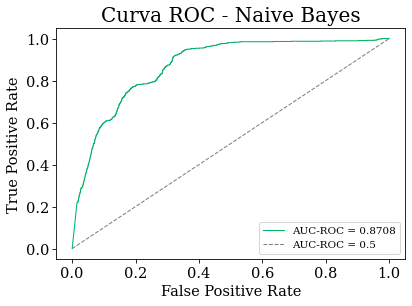

In [21]:
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb_yprob[:,1])
figura = plot_curva_roc(nb_fpr, nb_tpr, nb_rocauc, 'Naive Bayes')

#### Curva Precision-Recall

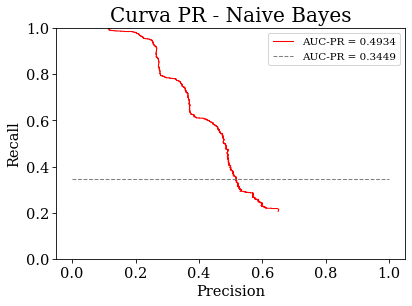

In [22]:
nb_precision, nb_recall, nb_thresholds_pr = precision_recall_curve(y_test, nb_yprob[:,1])
figura = plot_curva_pr(nb_precision, nb_recall, nb_aucpr, 'Naive Bayes')

#### Komogorov-Smirnov

In [23]:
df_clf_baseline = pd.DataFrame({'target': y_test, 'nb_yprob':nb_yprob[:,1]})


nb_stat_ks, nb_ks_val = ks(df_clf_baseline)

KS: 0.5959
p-valor: 0.0000


#### Separação de Classes

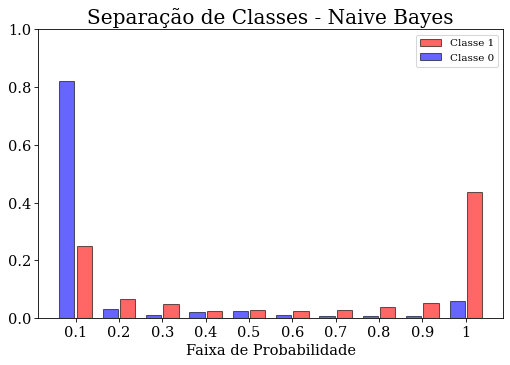

In [24]:
figura, classe0, classe1 = plot_separacao_classes(dataset=df_clf_baseline,
                                                 colunas=['nb_yprob'],
                                                 titulos=['Naive Bayes'],
                                                 modelo=modelo)

In [25]:
df_metrics = pracc_metrics(y_test, nb_yprob)

df_metrics['Class 0'] = classe0[0]
df_metrics['Class 1'] = classe1[0]
df_metrics['Class 0 Ratio'] = np.round( df_metrics['Class 0'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)
df_metrics['Class 1 Ratio'] = np.round( df_metrics['Class 1'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)

df_metrics

,percentil,tp,tn,fp,fn,precision,recall,accuracy,Class 0,Class 1,Class 0 Ratio,Class 1 Ratio
0,0.1000,695,6000,1310,233,0.6546,0.7849,0.8127,0.8208,0.2511,0.7658,0.2342
1,0.2000,634,6230,1080,294,0.6624,0.7677,0.8332,0.0315,0.0657,0.3237,0.6763
2,0.3000,590,6307,1003,338,0.6598,0.7493,0.8372,0.0105,0.0474,0.1818,0.8182
3,0.4000,566,6464,846,362,0.6739,0.7471,0.8534,0.0215,0.0259,0.4537,0.5463
4,0.5000,540,6639,671,388,0.6953,0.7451,0.8714,0.0239,0.0280,0.4608,0.5392
5,0.6000,516,6711,599,412,0.7025,0.7370,0.8773,0.0098,0.0259,0.2758,0.7242
6,0.7000,489,6770,540,439,0.7072,0.7265,0.8812,0.0081,0.0291,0.2172,0.7828
7,0.8000,455,6828,482,473,0.7104,0.7122,0.8841,0.0079,0.0366,0.1780,0.8220
8,0.9000,406,6887,423,522,0.7096,0.6898,0.8853,0.0081,0.0528,0.1326,0.8674
9,1.0000,191,7207,103,737,0.7784,0.5959,0.8980,0.0579,0.4375,0.1168,0.8832
